# Modelación del índice multivariado del ENOS mediante modelos ARMA/ARIMA

## 1. Introducción
"El niño / oscilación del sur **(ENOS)** es un estado anómalo de las condiciones oceano-atmósfera del pacífico tropical y es el pincipal predictor de las perturbaciones climáticas globales. Una correcta evaluación del **ENOS** es importante para una serie de servicios climáticos que informa las respuestas sociales y desencadenan acciones políticas para el suministro de agua, la salud y la seguridad pública"[1].

El índice multivariado del **ENOS (MEI)** hace uso de variables oceánicas y atmosféricas para dar un valor cuantificable a la intensidad con que se presenta el fenómeno del **ENOS** en tiempo real. El **MEI** se mide en periodos bimestrales que se traslapan, es decir, se consideran los periodos enero-febrero, febrero-marzo, marzo-abril, etc. Dicho índice considera las siguientes variables:
* Presión a nivel del mar **(SLP)**
* Temperatura de la superficie del mar **(SST)**
* Radiación de onda larga saliente **(OLR)**

además de otros componentes meridionales y de zona del viento superficial.

En el presente documento se realizará una predicción del comportamiento del **MEI** bimestral utilizando modelos **ARMA/ARIMA** para modelar el comportameinto de dicho índice a lo largo del tiempo. Se considera una base de datos con fecha de inicio del 1 de enero de 1818 y final de 31 de diciembre de 2019.

## 2. Presentación de los datos

### 2.1. Descripción del conjunto de datos
Se tiene el conjunto de datos **SOI-SSpot.csv** nombrados `df`, en donde las observaciones bimestrales del **MEI** se encuentran representados por la variable `MEI_bm`, cuya primera observación se encuentra registrada el dia 15 de enero de 1871 (`1871-01-15`) y la última observación registrada el 15 de diciembre de 2018 (`2018-12-15`). Observamos que `MEI_bm` cuenta con `75,144` datos de los cuales tan solo `1,776` son no-nulos, es decir, un `2.36%` respecto al total.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Cargamos los datos e indexamos por fecha
df = pd.read_csv('SOI-SSpot.csv', index_col='ND', low_memory=False)
df = df.rename(columns={'A':'year', 'M':'month', 'D':'day'})
df['Fecha'] = pd.to_datetime(df[['day', 'month', 'year']], errors='coerce')

print(df.columns)
print(df['MEI_bm'].info())

Xt = pd.DataFrame(df[['Fecha', 'MEI_bm']]).dropna().set_index('Fecha')
Xt.index = pd.date_range(start='1871-01-15', end='2018-12-15', freq='MS')

Index(['day', 'NM', 'month', 'year', 'id.M', 'id.A', 'Frac.Day', 'DJ',
       'Tahiti', 'Darwin', 'SOI.d', 'SOI.da', 'SOI.m', 'SOI.ma', 'SOI.bm',
       'SOI.tm', 'MEI_bm', 'SOI_m', 'SOI_ma', 'SOI_mb', 'SOI_mc', 'SOI_tm',
       'NAO_m', 'ONI_tm', 'POI_m', 'CyclSS', 'CyclSS.P', 'ExtSS', 'SS.nd',
       'SS.totm', 'SS.nm', 'SS.nbm', 'SS.ntm', 'SS.sd', 'no', 'id', 'SR.On',
       'SR.off', 'Est', 'E.Astro', 'E.Ast.H', 'E.Ast.Fecha', 'Fecha'],
      dtype='object')
<class 'pandas.core.series.Series'>
Index: 75144 entries, 1 to 73782
Series name: MEI_bm
Non-Null Count  Dtype  
--------------  -----  
1775 non-null   float64
dtypes: float64(1)
memory usage: 1.1 MB
None


### 2.2. Grafica de la serie de tiempo
Aislando las observaciones de la variable `MEI_bm` e indexándolas por fecha, podemos notar que las observaciones se registraron el día 15 de cada mes. Puesto que conocemos con certeza el comportamiento periódico de las observaciones, optamos por eliminar los valores nulos y realizar nuestro análisis solamente con las observaciones originales.

Al graficar los datos podemos observar una línea de tendencia en el *gráfico de dispersión* que parece sugerir una una tendencia creciente, sin embargo, dicha línea de tendencia cuenta con una pendiente de `1.42587e-10`, por lo que puede no ser significativa.

Por otra parte, en el *gráfico de líneas* no es visible ningún tipo de comportamiento periódico o tendencia. La aleatoriedad del gráfico de líneas sugiere que las predicciones a largo plazo pueden presentar grandes errores y, en su lugar, puede resultar más certero ralizar predicciones a corto plazo.

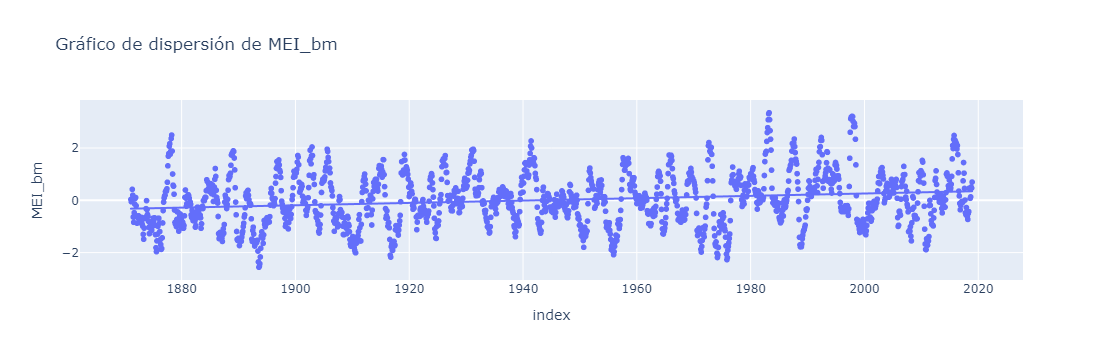

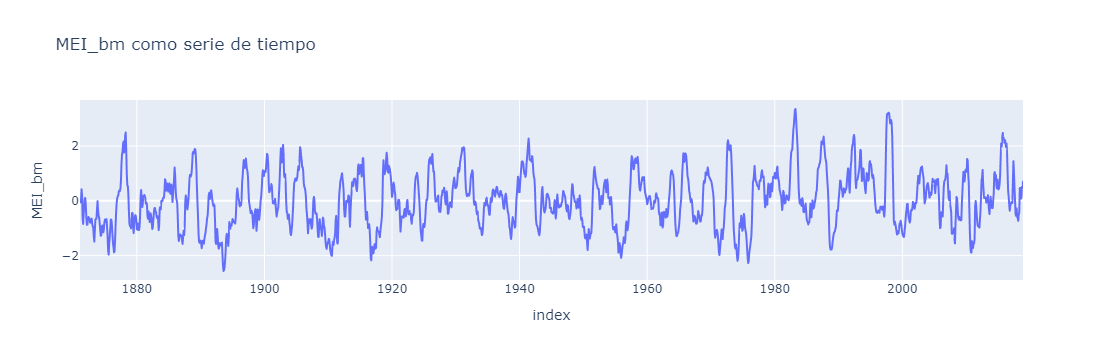

In [2]:
import plotly.express as px

Xt_scatterplot = px.scatter(Xt, title='Gráfico de dispersión de MEI_bm', y='MEI_bm', trendline='ols') # Gráfico de dispersión
Xt_lineplot = px.line(Xt, title='MEI_bm como serie de tiempo', y='MEI_bm')                            # Gráfico de líneas

Xt_scatterplot.show()
Xt_lineplot.show()

## 3. Análisis de estacionariedad de la serie

### 3.1. Histograma, Q-Qplot y Autocorrelograma

Dado el comportamiento observado en los gráficos anteriores, se procede a realizar un *histograma* de la misma en búsqueda de una distribución normal. Asimismo, se realiza un *Q-Qplot* para comparar los cuantiles de la distribución empírica de `MEI_bm` con una distribución normal.

En el histograma  podemos observar que los datos de la variable `MEI_bm` tienen un ligero sesgo hacia la derecha, es decir, hay más observaciones con valores altos que observaciones con valores bajos. Además, la línea de tendencia del histograma asemeja a la de una distribución normal. 

En el *Q-Qplot* se muestran valores extremos poco alejados de la diagonal, pero no de una forma significativa. Además, los valores centrales se ajustan muy bien a la diagonal, sugiriendo que los datos siguen una distribución normal.

Finalmente, se realiza un *autocorrelograma* de la serie de tiempo en donde se consideran 50 rezagos. En dicho gráfico podemos observar un decaimiento gradual de los datos, donde 12 parece haber un nivel de correlación significativo con por lo menos 12 de las observaciones inmediatamente anteriores, es decir, las observaciones de `MEI_bm` procedentes de un año enterior parecen tener repercusión significativa con las actuales. En términos de estacionariedad, el *autocorrelograma* parece indicar un serie no estacionaria.


La media muestral de los datos es de 0.013

La varianza de la muestra es de 0.988

La desviación estándar de la muestra es de 0.994



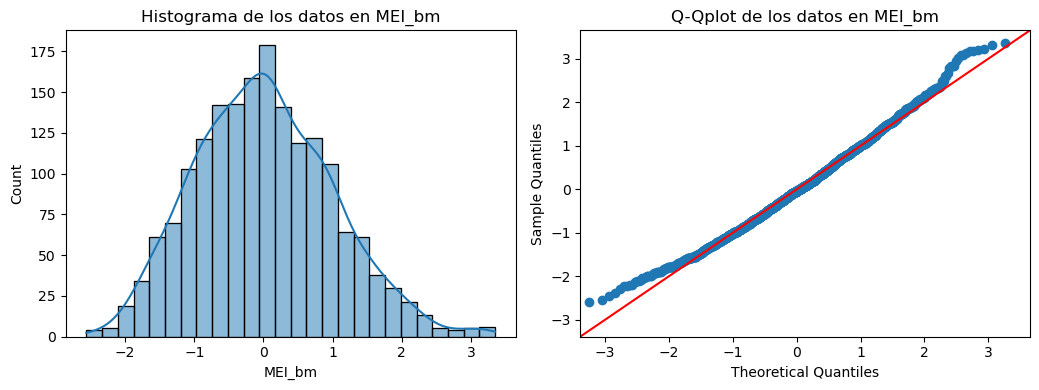

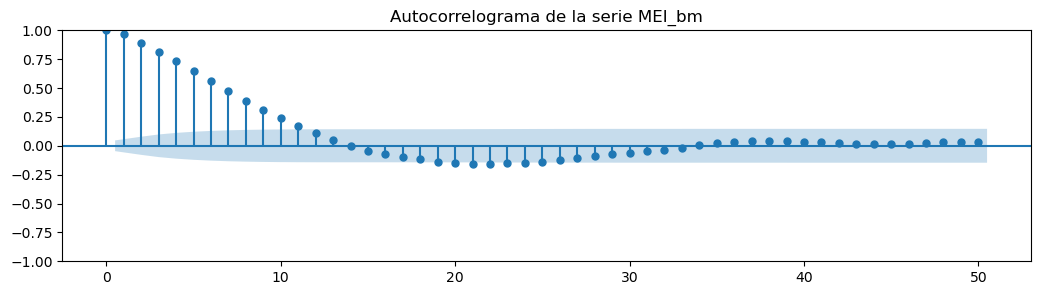

In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

MEI_bm_Xt = Xt['MEI_bm']

#-----------------------------------------Mostramos los estadísticos descriptivos de MEI_bm-----------------------------------------------------------------------
print(f'\nLa media muestral de los datos es de {MEI_bm_Xt.mean():.3f}')
print(f'\nLa varianza de la muestra es de {MEI_bm_Xt.var():.3f}')
print(f'\nLa desviación estándar de la muestra es de {MEI_bm_Xt.std():.3f}\n')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------Obtenemos un histograma y qqplot de MEI_bm--------------------------------------------------------------------------
_, ax = plt.subplots(1, 2, figsize=(10.5, 4))

# Histograma de MEI_bm
ax[0].set_title('Histograma de los datos en MEI_bm')
sns.histplot(MEI_bm_Xt, kde=True, ax=ax[0])

ax[1].set_title('Q-Qplot de los datos en MEI_bm')
sm.qqplot(MEI_bm_Xt, fit=True, line='45', loc=MEI_bm_Xt.mean(), ax=ax[1])

plt.tight_layout()
plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Autocorrelograma de MEI_bm
_, ax = plt.subplots(figsize=(12.5,3))
MEI_bm_Xt_acf = plot_acf(MEI_bm_Xt, title='Autocorrelograma de la serie MEI_bm', ax=ax, lags=50)
plt.show()

### 3.2. Prueba de Dickey-Fuller aumentada para MEI_bm

Dado que no se encontró un indicio claro sobre la estacionariedad de la serie en lo gráficos anteriores, se procede a realizar una prueba de Dickey-Fuller aumentada **(ADF)** para tomar una decisión sobre la estacionariedad de la serie. Para esta prueba se consideran las siguientes hipótesis:

* $H_0$: La serie es no estacionaria.
* $H_1$: La serie es estacionaria.

considerando un nivel de significancia $\alpha=0.05$, donde $H_0$ representa la hipótesis nula y $H_1$ la hipótesis alternativa.

Los resultados de la prueba muestran un *p-valor* de `0.000` menor a $\alpha$. Por lo tanto, se rechaza la hipótesis nula, es decir, se concluye que la serie es estacionaria.

In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_Xt = adfuller(MEI_bm_Xt)

print(f'\nEl valor del estadístico ADF es: {ADF_Xt[0]:.3f}')
print(f'\nEl p-valor obtenido es: {ADF_Xt[1]:.3f}')


El valor del estadístico ADF es: -8.782

El p-valor obtenido es: 0.000


## 4. Modelo ARMA / ARIMA
Dado que la serie de tiempo es estacionaria, se implementará como primera opción un un modelo **ARMA($p,q$)** para realizar predicciónes del **MEI**. Sin embargo, el lento decaimiento del autocorrelograma presentado anteriormente sugiere que un proceso de diferenciación puede ser conveniente para la serie, por lo que adicionalmente se implementará un modelo **ARIMA($p,1,q$)** y se realizarán las comparaciones adecuadas para evaluar la eficiencia de ambos modelos.

Comenzaremos dividiendo el conjunto de datos en datos de entrenamiento y de validación, con una relación `80-20`. Posteriormente, analizaremos los correlogramas de las funciones de autoccorrelación y autocorrelación parcial para obtener los valores óptimos de los componentes **AR($p$)** y **MA($q$)** en los correspondientes modelos.

### 4.1. Comparación de la primera diferenciación
En el *gráfico de dispresión* de la primera diferenciación de la serie (identificada como `diff_1`) podemos apreciar que la pendiente de la línea de tendencia disminuyó. 

Posteriormente, se aplicó una prueba **ADF** con nivel de significancia $\alpha=0.05$, en donde se obtuvo un *p-valor* de `0.000`, menor a $\alpha$. Por lo tanto, se rechaza la hipótesis nula para `diff_1`, es decir, la serie continúa siendo estacionaria tras la primera diferenciación.

Adicionalmente, podemos observar como la autocorrelación decae significativamente más rápido tras la primera diferenciación, en la cual solo los dos primeros valores parecen significativos. Si bien un deacimiento abrupto puede ser indicio de una sobrediferenciación, la eficiencia entre el modelo correspondiente a la serie diferenciada y el correspondiente a la serie original será evaluada más adelante.

Finalmente, en el *gráfico de líneas* podemos apreciar como la variación de los datos a lo largo del tiempo se redujo de manera considerable al diferenciar la serie. En términos de modelado, el modelo resultante podría no captar la variación necesaria para hacer predicciones certeras.

In [5]:
import statsmodels.tsa.api as tsa
from sklearn.model_selection import train_test_split

train, test = train_test_split(Xt, test_size=0.2, shuffle=False) # Dividimos en datos de entrenamiento y datos de prueba
diff_1 = train.diff().dropna()                                   # Realizamos la primer diferenciación

#--------------------------------------------------------Grafico de dispersión y de líneas------------------------------------------------------------------------
diff_1_scatter = px.scatter(diff_1, trendline='ols', title='Gráfico de dispersión de la primera diferenciación', y='MEI_bm') # Gráfico de dispersión
diff_1_lineplot = px.line(y=[train['MEI_bm'][1:], diff_1['MEI_bm']], color_discrete_sequence=['blue', 'orange'])             # Gráfico de líneas
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Aplicamos la prueba de Dickey-Fuller y mostramos los resultados
ADF_diff_1 = adfuller(diff_1)
print(f'\nEl valor del estadístico ADF es: {ADF_diff_1[0]:.3f}')
print(f'\nEl p-valor obtenido es: {ADF_diff_1[1]:.3f}\n')

diff_1_scatter.show()
diff_1_lineplot.show()


El valor del estadístico ADF es: -11.355

El p-valor obtenido es: 0.000



### 4.2. Búsqueda de los valores AR y MA
Analizando con detenimiento los diagramas de autocorrelación y autocorrelación parcial asociados a `MEI_bm` podemos notar que

* Los primeros `12` rezagos de autocorrelación son notablemente significativos.
* Los primeros `8` rezagos de autocorrelación parcial son notablemente significativos.

Por lo tanto, se espera que valores $p=1,\dots,8$ y $q=1,\dots,12$ para un modelo **ARMA$(p,q)$** expliquen correctamente el comportameinto del **MEI**.

Por otra parte, al analizar los diagramas de autocorrelación y autocorrelación parcial asociados a `diff_1` podemos notar que

* Los primeros `2` rezagos de autocorrelación son notablemente significativos.
* Los primeros `10` rezagos de autocorrelación parcial son notablemente significativos.

Por lo tanto, se espera que valores $p=1,\dots,10$ y $q=1,2$ para un modelo **ARIMA($p,1,q$)** expliquen correctamente el comportamiento del **MEI**.

Para evaluar la eficiencia del modelos según los valores $p$ y $q$, consideraremos el *criterio de información de Akaike* **(AIC)** y el *criterio de información Bayesiano* **(BIC)**, tomando los valores $p$ y $q$ que minimicen estos criterios. En el caso del modelo **ARMA** se optará por un enfoque clásico en el que cada uno de los posibles valores $p$ y $q$ sea evaluado. En contraste, para el modelo **ARIMA** se optará por usar la función `auto_arima`, la cual encuentra los valores óptimos para $p$ y $q$ respecto al criterio especificado.

Los resultados del entrenamiento de los distintos modelos muestra que los siguientes modelos son óptimos respecto a los parámetros establecidos:
* ARMA(4, 2) para AIC y BIC mínimos.
* ARIMA(2, 1, 5) para AIC.
* ARIMA(0, 1, 3) para BIC.

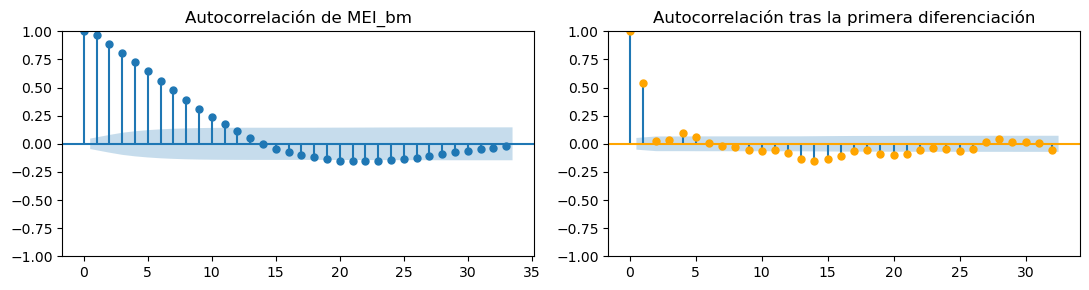

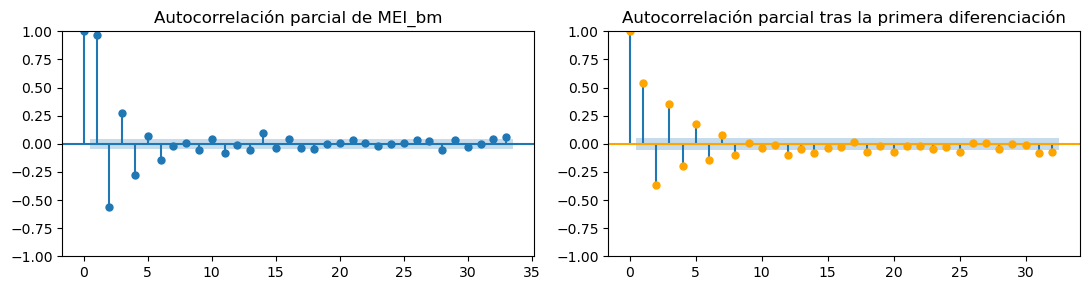

In [6]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

#------------------------------------------------------Comparamos autocorrelación y autocorrelación parcial-------------------------------------------------------

_, ax = plt.subplots(1, 2, figsize=(11,3)) # Autocorrelación
MEI_bm_Xt_acf = plot_acf(MEI_bm_Xt, title='Autocorrelación de MEI_bm', ax=ax[0])
diff_1_acf = plot_acf(diff_1, title='Autocorrelación tras la primera diferenciación', ax=ax[1], color='orange')

plt.tight_layout()
plt.show()

_, ax = plt.subplots(1, 2, figsize=(11,3)) # Autocorrelación parcial
MEI_bm_Xt_pacf = plot_pacf(MEI_bm_Xt, title='Autocorrelación parcial de MEI_bm', ax=ax[0])
diff_1_pacf = plot_pacf(diff_1, title='Autocorrelación parcial tras la primera diferenciación', ax=ax[1], color='orange')

plt.tight_layout() 
plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

valores_AIC = []
valores_BIC = []

In [7]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)

# Entrenamos y medimos la eficiencia de los modelos
for p in range(8):       # Consideramos valores p in range(1,8). Si el proceso es lento -> p in range(1,5)
    for q in range(3):   # Consideramos valores p in range(1,3). Si el proceso es lento -> p in range(1,3)
        modelo_MEI_bm = ARIMA(train, order=(p, 0, q)).fit()
        valores_AIC.append((p, q, modelo_MEI_bm.aic))
        valores_BIC.append((p, q, modelo_MEI_bm.bic))

In [8]:
# Identificamos los valores p y q minimos de acuerdo al AIC y BIC respectivamente
AIC = min(valores_AIC, key=lambda x: x[2])
BIC = min(valores_BIC, key=lambda x: x[2])

# Mostramos los valores p y q óptimos
print(f'\nLos mejores valores según el AIC son p={AIC[0]} y q={AIC[1]}')
print(f'\nLos mejores valores según el BIC son p={BIC[0]} y q={BIC[1]}')


Los mejores valores según el AIC son p=4 y q=2

Los mejores valores según el BIC son p=4 y q=2


In [9]:
modelo_MEI_bm = ARIMA(train, order=(4, 0, 2)).fit()    # Entrenamos el modelo ARMA(4,2)

In [10]:
from pmdarima import auto_arima
# Entrenamos el modelo ARIMA(p, 1, q) minimizando el AIC
auto_modelo_MEI_bm_aic = auto_arima(train, 
                                    d=1,  # Consideramos una sola diferenciación
                                    information_criterion='aic',
                                    seasonal=False,
                                    trace=False, 
                                    stepwise=True)

In [11]:
#Entrenamos el modelo ARIMA(p, 1, q) minimizando el BIC
auto_modelo_MEI_bm_bic = auto_arima(train,
                                   d=1,  # Consideramos una sola diferenciación
                                   information_criterion='bic',
                                   seasonal=False,
                                   trace=False,
                                   stepwise=True)

### 4.3. Análisis de los residuos
Para asegurar la efectividad de los modelos, es necesario comprender el comportamiento de los residuos. En aprticular, se busca que los residuos de los distintos modelos se comporten como ruido blanco, es decir, que los residuos

* No están autocorrelacionados.
* Tienen media cero.
* Tienen varianza constante.

De otra forma, sería necesario modelar el ruido mediante métodos más complicados, los cuales no se abordarán en este documento.

In [12]:
# Obtenemos los residuos
residuos_MEI_bm = modelo_MEI_bm.resid
residuos_aic = auto_modelo_MEI_bm_aic.resid()
residuos_bic = auto_modelo_MEI_bm_bic.resid()

# Gráfico de dispersión de los residuos
opacidades = [0.7] * (len(residuos_MEI_bm) + len(residuos_aic) + len(residuos_bic))
residuos_MEI_bm_scatter = px.scatter(y=[residuos_MEI_bm, residuos_aic, residuos_bic], opacity=opacidades)
residuos_MEI_bm_scatter.show()

#### 4.3.1. Prueba de Ljung-Box

Para confirmar que no existe autocorrelación significativa en los residuos, utilizaremos la prueba de Ljung-Box planteando las siguientes hipótesis:
* $H_0$: No hay autocorrelación en los residuos.
* $H_1$: Existe autocorrelación en los residuos.

considerando un nivel de significancia $\alpha=0.05$. Considerando retrasos de hasta 12 periodos (un año) obtenemos los siguientes resultados:
* Todos los $p$-valores del modelo ARMA son notablemente mayores a $\alpha$.
* Todos los $p$-valores del modelo ARIMA(2,1,5) son notablemente mayores a $\alpha$.
* Todos los $p$-valores del modelo ARIMA(0,1,3) son mayores a $\alpha$ solo durante los primeros 12 periodos.

Por lo tanto, no se rechaza la hipótesis nula para los modelos **ARMA** y **ARIMA(2,1,5)**. Para el modelo **ARIMA(0,1,3)**, la hipótesis nula no se rechaza en los primeros 12 rezagos, sin embargo, existe evidencia de autocorrelación en los residuos tras 12 rezagos, lo cual puede ser causa de errores en las predicciones del correspondiente modelo.

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

print(f'\nLos p-valor para ARMA(4,2) son\n {acorr_ljungbox(residuos_MEI_bm, lags=24)}')
print(f'\nLos p-valor para ARIMA(2,1,5) son\n {acorr_ljungbox(residuos_aic, lags=24)}')
print(f'\nLos p-valor para ARIMA(0,1,3) son\n {acorr_ljungbox(residuos_bic, lags=24)}')


Los p-valor para ARMA(4,2) son
       lb_stat  lb_pvalue
1    0.006318   0.936647
2    0.019378   0.990358
3    0.100662   0.991758
4    0.166143   0.996735
5    0.411301   0.995013
6    0.784912   0.992472
7    1.083809   0.993361
8    1.427019   0.993854
9    1.537958   0.996855
10   1.678543   0.998263
11   4.550623   0.950966
12   4.551677   0.971305
13   5.404356   0.965181
14   7.064315   0.932204
15   7.100601   0.954798
16   7.919688   0.951221
17   9.617521   0.918879
18  11.390499   0.877057
19  12.062151   0.882952
20  12.291474   0.905678
21  14.260659   0.858145
22  14.883658   0.867182
23  14.884971   0.898709
24  14.926561   0.922889

Los p-valor para ARIMA(2,1,5) son
       lb_stat  lb_pvalue
1    0.010576   0.918090
2    0.018332   0.990876
3    1.529347   0.675514
4    1.593371   0.809983
5    1.594629   0.901898
6    2.256757   0.894636
7    2.261419   0.943967
8    2.459786   0.963580
9    2.781751   0.972323
10   4.147390   0.940453
11   6.852393   0.810908
12   7

#### 4.3.2. Prueba de Jarque-Bera
Con los estadísticos descriptivos, el *histograma* comparativo y el *Q-Qplot*, podemos observar que los residuos de los distintos modelos asemejan a una distribución normal $N(0,0.3)$. Sin embargo, dado que lo anterior no es suficiente para concluir que dichos residuos provienen efectivamente de una distribución normal, realizamos una *prueba de normalidad de Jarque-Bera*, en la que planteamos las siguientes hipótesis:

* $H_0$: Los residuos siguen una distribución normal.
* $H_1$: Los residuos no siguen una distribución normal.

Donde $H_0$ es la hipótesis nula, $H_1$ la hipótesis alternativa y se considera un nivel de significancia $\alpha=0.05$. Los resultados de las pruebas son los siguientes:

* El $p$-valor de la prueba aplicada al modelo **ARMA** es `0.867`.
* El $p$-valor de la prueba aplicada al modelo **ARIMA(2,1,5)** es `0.513`.
* El $p$-valor de la prueba aplicada al modelo **ARIMA(0,1,3)** es `0.369`.

En los tres casos podemos observar que el $p$-valor calculado es mayor a $\alpha$, por lo que en ninguno de los casos se rechaza la hipótesis nula. De esta forma, no existe evidencia significativa para decir que los residuos no siguen una distribución normal.


La media de los residuos del modelo ARMA es 0.000

La media de los residuos del modelo ARIMA(2,1,5) es 0.000

La media de los residuos del modelo ARIMA(0,1,3) es -0.000

La varianza de los residuos del modelo ARMA es 0.029

La varianza de los residuos del modelo ARIMA(2,1,5) es 0.030

La varianza de los residuos del modelo ARIMA(0,1,3) es 0.031

El p-valor de la prueba aplicada al modelo ARMA es 0.867

El p-valor de la prueba aplicada al modelo ARIMA(2,1,5) es 0.513

El p-valor de la prueba aplicada al modelo ARIMA(0,1,3) es 0.369



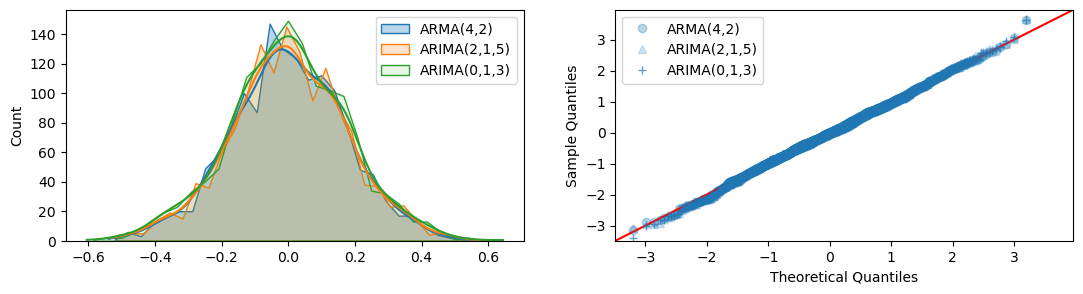

In [14]:
from statsmodels.stats.api import jarque_bera

# Obtenemos los promedios de los residuos
print(f'\nLa media de los residuos del modelo ARMA es {residuos_MEI_bm.mean():.3f}')
print(f'\nLa media de los residuos del modelo ARIMA(2,1,5) es {residuos_aic.mean():.3f}')
print(f'\nLa media de los residuos del modelo ARIMA(0,1,3) es {residuos_bic.mean():.3f}')

# Obtenemos las varianzas de los residuos
print(f'\nLa varianza de los residuos del modelo ARMA es {residuos_MEI_bm.var():.3f}')
print(f'\nLa varianza de los residuos del modelo ARIMA(2,1,5) es {residuos_aic.var():.3f}')
print(f'\nLa varianza de los residuos del modelo ARIMA(0,1,3) es {residuos_bic.var():.3f}')

# Obtenemos los p-valores de la prueba de Jarque-Bera
print(f'\nEl p-valor de la prueba aplicada al modelo ARMA es {jarque_bera(residuos_MEI_bm)[1]:.3}')
print(f'\nEl p-valor de la prueba aplicada al modelo ARIMA(2,1,5) es {jarque_bera(residuos_aic)[1]:.3}')
print(f'\nEl p-valor de la prueba aplicada al modelo ARIMA(0,1,3) es {jarque_bera(residuos_bic)[1]:.3}\n')

#---------------------------------------------------------------Gráficos de los residuos--------------------------------------------------------------------------

# Histograma de los residuos
_, ax = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(residuos_MEI_bm, kde=True, alpha=0.3, element='poly',  bins=30, ax=ax[0], label='ARMA(4,2)')
sns.histplot(residuos_aic, kde=True, alpha=0.2, element='poly',  bins=30, ax=ax[0], label='ARIMA(2,1,5)')
sns.histplot(residuos_bic, kde=True, alpha=0.1, element='poly',  bins=30, ax=ax[0], label='ARIMA(0,1,3)')
ax[0].legend()

# Q-Qplot de los residuos
sm.qqplot(residuos_MEI_bm, fit=True, line='45', loc=residuos_MEI_bm.mean(), alpha=0.3, label='ARMA(4,2)', ax=ax[1])
sm.qqplot(residuos_aic, fit=True, alpha=0.2, color='orange', label='ARIMA(2,1,5)', marker='^', ax=ax[1])
sm.qqplot(residuos_bic, fit=True, alpha=0.7, color='green', label='ARIMA(0,1,3)', marker='+', ax=ax[1])
ax[1].legend()

plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#### 4.3.3. Prueba de Breusch-Pagan

Finalmente, comprobaremos si la varianza de los residuos es constante, es decir, verificaremos la existencia de homocedasticidad. Para ello, utilizaremos la *prueba de heterocedasticidad de Breusch-Pagan*, en donde se plantean las siguientes hipótesis:

* $H_0$: No existe heterocedasticidad en los residuos.
* $H_1$: Existe heterocedasticidad en los residuos.

Donde $H_0$ denota la hipótesis nula, $H_1$ la hipótesis alternativa y se considera un nivel de significancia $\alpha=0.05$. Se obtuvieron los siguientes resultados:

* El $p$-valor de la prueba aplicada al modelo **ARMA** es `0.001`.
* El $p$-valor de la prueba aplicada al modelo **ARIMA(2,1,5)** es `0.001`.
* El $p$-valor de la prueba aplicada al modelo **ARIMA(0,1,3)** es `0.005`.

Podemos observar que en los tres casos el $p$-valor de la prueba es menor a $\alpha$, por lo que en todos los casos se rechaza la hipótesis nula. De esta forma, se tiene evidencia significativa para considerar que los residuos de los modelos presentan heterocedasticidad, lo cual podría presentar problemas en la aplicación del modelo.

In [15]:
from statsmodels.stats.diagnostic import het_breuschpagan
from numpy import arange
import statsmodels.api as sm

X = sm.add_constant(arange(len(residuos_aic)))

print(f'El p-valor asociado al modelo ARMA es {het_breuschpagan(residuos_MEI_bm, X)[1]:.3f}')
print(f'El p-valor asociado al modelo ARIMA(2,1,5) es {het_breuschpagan(residuos_aic, X)[1]:.3f}')
print(f'El p-valor asociado al modelo ARIMA(0,1,3) es {het_breuschpagan(residuos_bic, X)[1]:.3f}')

El p-valor asociado al modelo ARMA es 0.001
El p-valor asociado al modelo ARIMA(2,1,5) es 0.001
El p-valor asociado al modelo ARIMA(0,1,3) es 0.005


## 5. Predicciones del MEI

### 5.1. Predicciones a largo plazo del modelo ARMA
Podemos observar que el modelo se adapta bien a los datos de entrenamiento. Sin embargo, las predicciones de datos no conocidos por el modelo no se ajustan bien a las observaciones, pues las mismas no se encuentran dentro del intervalo de confianza del modelo, además de que ambas gráficas son notablemente distintas en el intervalo de predicción (después de la línea roja).

Los errores totales calculados son:
* Error absoluto medio **(MAE)**: `0.27`.
* Error cuadrático medio **(MSE)**: `0.25`.
* Raíz del error cuadrático medio **(RMSE)**: `0.5`.

Miesntras que los errores considerando solo las predicciones son:
* Error absoluto medio **(MAE)**: `0.8`.
* Error cuadrático medio **(MSE)**: `1.1`.
* Raíz del error cuadrático medio **(RMSE)**: `1.06`.


MAE del modelo: 0.27

MSE del modelo: 0.25

RMSE del modelo: 0.50

MAE de las predicciones: 0.80

MSE de las predicciones: 1.12

RMSE de las predicciones: 1.06



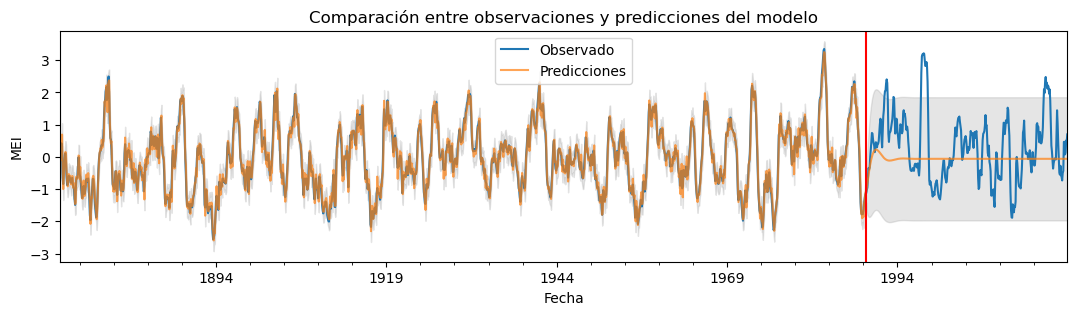

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#-------------------------------------------Obtenemos predicciones e intervalos de confianza usando el modelo ARMA(4,2)-------------------------------------------
predicciones_MEI = modelo_MEI_bm.get_prediction(start=MEI_bm_Xt.index[0], end=MEI_bm_Xt.index[-1])
y_pred = predicciones_MEI.predicted_mean
intervalos_confianza = predicciones_MEI.conf_int()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------Graficamos las predicciones y los intervalos de confianza------------------------------------------------------
ax = MEI_bm_Xt.plot(label='Observado', figsize=(13, 3), title='Comparación entre observaciones y predicciones del modelo')
y_pred.plot(ax=ax, label='Predicciones', alpha=0.7)
ax.fill_between(intervalos_confianza.index, intervalos_confianza.iloc[:, 0], intervalos_confianza.iloc[:, 1], color='gray', alpha=0.2) # Intervalos de confianza
ax.set_xlabel('Fecha')
ax.set_ylabel('MEI')
plt.legend()

pred_index = train.index[-1]
plt.axvline(x=pred_index, color='red') # Graficamos una línea vertical donde comienzan los datos de prueba
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------Errores totales del modelo---------------------------------------------------------------------------
MAE_total_MEI = mean_absolute_error(MEI_bm_Xt, y_pred)
MSE_total_MEI = mean_squared_error(MEI_bm_Xt, y_pred)
RMSE_total_MEI = np.sqrt(MSE_total_MEI)

print(f'\nMAE del modelo: {MAE_total_MEI:.2f}')
print(f'\nMSE del modelo: {MSE_total_MEI:.2f}')
print(f'\nRMSE del modelo: {RMSE_total_MEI:.2f}')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------Errores en las predicciones--------------------------------------------------------------------------
MAE_pred_MEI = mean_absolute_error(MEI_bm_Xt[pred_index:], y_pred[pred_index:])
MSE_pred_MEI = mean_squared_error(MEI_bm_Xt[pred_index:], y_pred[pred_index:])
RMSE_pred_MEI = np.sqrt(MSE_pred_MEI)

print(f'\nMAE de las predicciones: {MAE_pred_MEI:.2f}')
print(f'\nMSE de las predicciones: {MSE_pred_MEI:.2f}')
print(f'\nRMSE de las predicciones: {RMSE_pred_MEI:.2f}\n')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.show()

### 5.2. Predicciones a largo plazo de los modelos ARIMA

Podemos observar que el comportamiento del modelo **ARIMA(2,1,5)** es similar al del modelo **ARMA**, donde el intervalo de confianza abarca de mejor manera a los datos reales. Para este modelo se tienen errores totales calculados

* **MAE** = `0.27`.
* **MSE** = `0.24`.
* **RMSE** = `0.49`.

Luego, los errores en las predicciones del modelo **ARIMA(2,1,5)** son de

* **MAE** = `0.79`.
* **MSE** = `1.07`.
* **RMSE** = `1.03`.

Notemos que el error en las predicciones es bastante similar con respecto a las del modelo **ARMA**. Por otra parte, el modelo **ARIMA(0,1,3)** presenta una gráfica bastante inexacta, a la vez que se tienen las siguientes métricas:

* **MAE** = `0.41`.
* **MSE** = `0.65`.
* **RMSE** = `0.81`.

Los cuales son errores totales notablemente mayores con respecto a los modelos anteriores. Finalmente, los errores en las predicciones del modelo **ARIMA(0,1,3)** son

* **MAE** = `1.48`.
* **MSE** = `3.11`.
* **RMSE** = `1.76`.

Los cuales son notablemente mayores con respecto a los modelos anteriores.


MAE, MSE, RMSE del modelo ARIMA(2,1,5): 0.27, 0.24, 0.49

MAE, MSE, RMSE del modelo ARIMA(0,1,3): 0.41, 0.65, 0.81

MAE, MSE, RMSE de las predicciones del modelo ARIMA(2,1,5): 0.79, 1.07, 1.03

MAE, MSE, RMSE de las predicciones del modelo ARIMA(0,1,3): 1.48, 3.11, 1.76



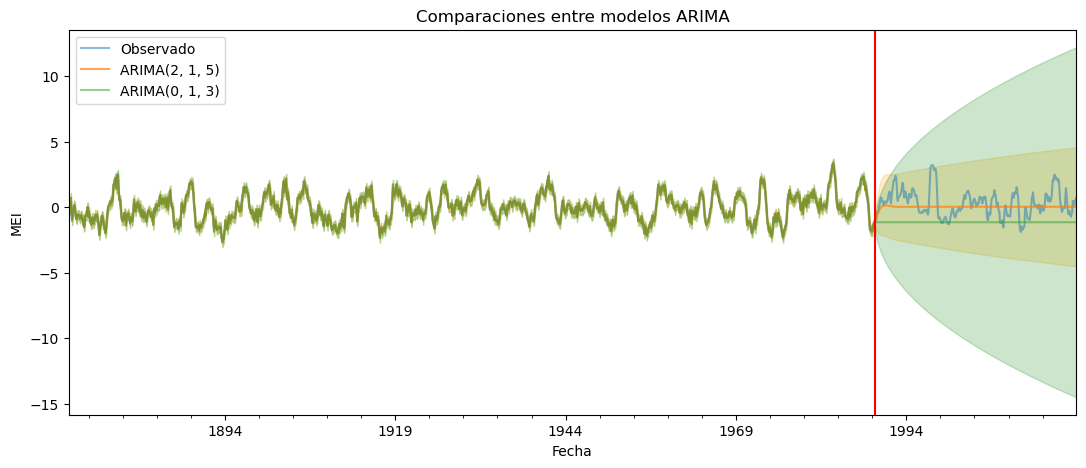

In [17]:
#--------------------------------------------------Predicciones de los modelos-----------------------------------------------------------------------------------
# Realizamos predicciones de las muestras y obtenemos sus intervalos de confianza
auto_aic_pred_in, intervalos_confianza_aic_in = auto_modelo_MEI_bm_aic.predict_in_sample(return_conf_int=True)
auto_bic_pred_in, intervalos_confianza_bic_in = auto_modelo_MEI_bm_bic.predict_in_sample(return_conf_int=True)

n_periods = len(MEI_bm_Xt) - len(train) # Número de periodos a predecir

# Realizamos predicciones de valores futuros y obtenemos sus intervalos de confianza
auto_aic_pred_out, intervalos_confianza_aic_out = auto_modelo_MEI_bm_aic.predict(return_conf_int=True, n_periods=n_periods)
auto_bic_pred_out, intervalos_confianza_bic_out = auto_modelo_MEI_bm_bic.predict(return_conf_int=True, n_periods=n_periods)
#----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Unimos las predicciones en una predicción global
auto_aic_pred = pd.concat([auto_aic_pred_in, auto_aic_pred_out])
auto_bic_pred = pd.concat([auto_bic_pred_in, auto_bic_pred_out])

# Unimos los intervalos de confianza para graficarlos
intervalos_confianza_aic = np.concatenate((intervalos_confianza_aic_in, intervalos_confianza_aic_out))
intervalos_confianza_bic = np.concatenate((intervalos_confianza_bic_in, intervalos_confianza_bic_out))

# Convertimos los arrays en DataFrames
intervalos_confianza_aic = pd.DataFrame(intervalos_confianza_aic, index=MEI_bm_Xt.index)[1:]
intervalos_confianza_bic = pd.DataFrame(intervalos_confianza_bic, index=MEI_bm_Xt.index)[1:]

#-------------------------------------------Graficamos los valores y las predicciones-----------------------------------------------------------------------------
ax = MEI_bm_Xt.plot(label='Observado', figsize=(13, 5), title='Comparaciones entre modelos ARIMA', alpha=0.5)
auto_aic_pred.plot(ax=ax, label='ARIMA(2, 1, 5)', alpha=0.7)
auto_bic_pred.plot(ax=ax, label='ARIMA(0, 1, 3)', alpha=0.5)
ax.fill_between(intervalos_confianza_aic.index, intervalos_confianza_aic.iloc[:, 0], intervalos_confianza_aic.iloc[:, 1], color='orange', alpha=0.2)
ax.fill_between(intervalos_confianza_bic.index, intervalos_confianza_bic.iloc[:, 0], intervalos_confianza_bic.iloc[:, 1], color='green', alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('MEI')
plt.legend()
plt.axvline(train.index[-1], color='red')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------Errores totales de ambos modelos------------------------------------------------------------------------
# Errores totales del modelo ARIMA(2,1,5)
MAE_total_aic = mean_absolute_error(MEI_bm_Xt, auto_aic_pred)
MSE_total_aic = mean_squared_error(MEI_bm_Xt, auto_aic_pred)
RMSE_total_aic = np.sqrt(MSE_total_aic)

# Errores totales del modelo ARIMA(0,1,3)
MAE_total_bic = mean_absolute_error(MEI_bm_Xt, auto_bic_pred)
MSE_total_bic = mean_squared_error(MEI_bm_Xt, auto_bic_pred)
RMSE_total_bic = np.sqrt(MSE_total_bic)

print(f'\nMAE, MSE, RMSE del modelo ARIMA(2,1,5): {MAE_total_aic:.2f}, {MSE_total_aic:.2f}, {RMSE_total_aic:.2f}')
print(f'\nMAE, MSE, RMSE del modelo ARIMA(0,1,3): {MAE_total_bic:.2f}, {MSE_total_bic:.2f}, {RMSE_total_bic:.2f}')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------Errores en las predicciones de ambos modelos----------------------------------------------------------------
# Errores en las predicciones del modelo ARIMA(2,1,5)
MAE_pred_aic = mean_absolute_error(MEI_bm_Xt[pred_index:], auto_aic_pred[pred_index:])
MSE_pred_aic = mean_squared_error(MEI_bm_Xt[pred_index:], auto_aic_pred[pred_index:])
RMSE_pred_aic = np.sqrt(MSE_pred_aic)

# Errores en las predicciones del modelo ARIMA(0,1,3)
MAE_pred_bic = mean_absolute_error(MEI_bm_Xt[pred_index:], auto_bic_pred[pred_index:])
MSE_pred_bic = mean_squared_error(MEI_bm_Xt[pred_index:], auto_bic_pred[pred_index:])
RMSE_pred_bic = np.sqrt(MSE_pred_bic)

print(f'\nMAE, MSE, RMSE de las predicciones del modelo ARIMA(2,1,5): {MAE_pred_aic:.2f}, {MSE_pred_aic:.2f}, {RMSE_pred_aic:.2f}')
print(f'\nMAE, MSE, RMSE de las predicciones del modelo ARIMA(0,1,3): {MAE_pred_bic:.2f}, {MSE_pred_bic:.2f}, {RMSE_pred_bic:.2f}\n')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.show()

### 5.3. Predicciones a corto plazo

Dado que los modelos **ARMA/ARIMA** consideran tanto los datos más recientes como los antiguos, optaremos por realizar la predicción a corto plazo a partir de los modelos que ya hemos ajustado, es decir, consideraremos la totalidad de los datos de la serie de tiempo para realizar la predicción.

Considerando una predicción de aproximadamente dos años, podemos observar que los modelos **ARMA(4,2)** y **ARIMA(2,1,5)** se ajustan bien a los datos reales durante el primer año, mientras que el modelo **ARIMA(0,1,3)** no muestra coincidencias con los datos reales. Comparando las métricas de los tres modelos obtenemos:

* Errores totales del modelo **ARMA**:$\qquad$$\qquad$$\qquad$**MAE**= `0.238`, $\qquad$**MSE**= `0.098`, $\qquad$**RMSE**= `0.314`.
* Errores totales del modelo **ARIMA(2,1,5)**:$\qquad$$\quad$**MAE**= `0.278`, $\qquad$**MSE**= `0.125`, $\qquad$**RMSE**= `0.353`.
* Errores totales del modelo **ARIMA(0,1,3)**:$\qquad$$\quad$**MAE**= `1.196`, $\qquad$**MSE**= `1.786`, $\qquad$**RMSE**= `1.336`.

Mientras que para los errores en las predicciones se tiene:

* Errores en las predicciones del modelo **ARMA**: $\qquad$$\qquad$**MAE**= `0.238`, $\qquad$**MSE**=`0.098`, $\qquad$**RMSE**= `0.314`.
* Errores en las predicciones del modelo **ARIMA(2,1,5)**: $\quad$**MAE**= `0.278`, $\qquad$**MSE**= `0.125`, $\qquad$**RMSE**= `0.353`.
* Errores en las predicciones del modelo **ARIMA(0,1,3)**: $\quad$**MAE**= `1.196`, $\qquad$**MSE**= `1.786`, $\qquad$**RMSE**= `1.336`.

Podemos observar que los errores del modelo **ARIMA(0,1,3)** son muy grandes en comparación a los otros modelos, mientras que los erores del los modelos **ARMA(4,2)** y **ARIMA(2,1,5)** son similares y considerablemente bajos.


MAE, MSE, RMSE totales de ARMA: 0.238, 0.098, 0.314

MAE, MSE, RMSE totales de ARIMA(2,1,5): 0.278, 0.125, 0.353

MAE, MSE, RMSE totales de ARIMA(0,1,3): 1.196, 1.786, 1.336

MAE, MSE, RMSE en las predicciones de ARMA: 0.238, 0.098, 0.314

MAE, MSE, RMSE en las predicciones de ARIMA(2,1,5): 0.278, 0.125, 0.353

MAE, MSE, RMSE en las predicciones de ARIMA(0,1,3): 1.196, 1.786, 1.336



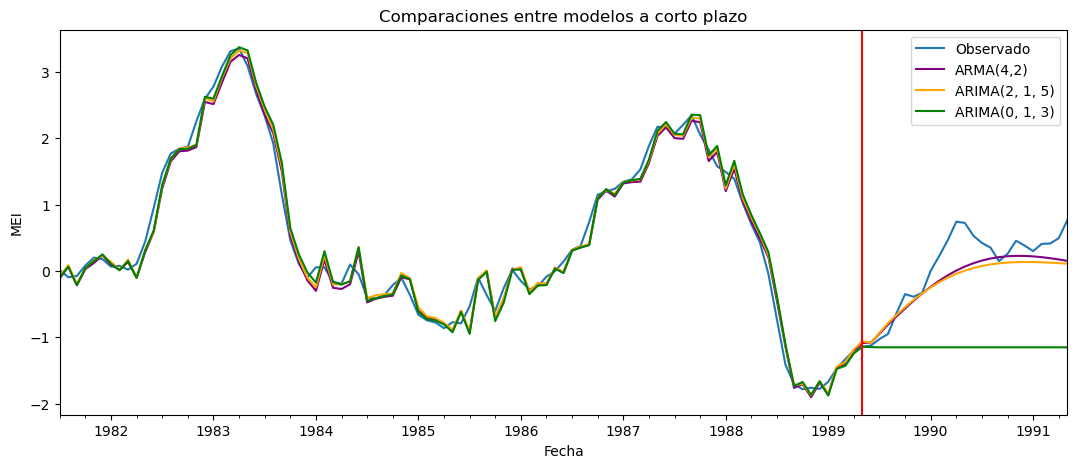

In [18]:
start = int(len(auto_aic_pred_in) - (len(auto_aic_pred_in) / 15))
end = - int(len(auto_aic_pred_out) - (len(auto_aic_pred_out) / 15))

MEI_bm_Xt_corto = MEI_bm_Xt[start:end]
y_pred_corto = y_pred[start:end]
auto_aic_pred_corto = auto_aic_pred[start:end]
auto_bic_pred_corto = auto_bic_pred[start:end]

#------------------------------------------------------------Gráfica de los modelos a corto plazo-----------------------------------------------------------------
ax = MEI_bm_Xt_corto.plot(label='Observado', figsize=(13, 5), title='Comparaciones entre modelos a corto plazo')
y_pred_corto.plot(ax=ax, label='ARMA(4,2)', color='purple')
auto_aic_pred_corto.plot(ax=ax, label='ARIMA(2, 1, 5)', color='orange')
auto_bic_pred_corto.plot(ax=ax, label='ARIMA(0, 1, 3)', color='green')
ax.set_xlabel('Fecha')
ax.set_ylabel('MEI')
plt.legend()
plt.axvline(train.index[-1], color='red')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Errores totales del modelo ARMA
MAE_total_MEI_corto = mean_absolute_error(MEI_bm_Xt_corto[pred_index:], y_pred_corto[pred_index:])
MSE_total_MEI_corto = mean_squared_error(MEI_bm_Xt_corto[pred_index:], y_pred_corto[pred_index:])
RMSE_total_MEI_corto = np.sqrt(MSE_total_MEI_corto)

# Errores totales del modelo ARIMA(2,1,5)
MAE_total_aic_corto = mean_absolute_error(MEI_bm_Xt_corto[pred_index:], auto_aic_pred_corto[pred_index:])
MSE_total_aic_corto = mean_squared_error(MEI_bm_Xt_corto[pred_index:], auto_aic_pred_corto[pred_index:])
RMSE_total_aic_corto = np.sqrt(MSE_total_aic_corto)

# Errores totales del modelo ARIMA(0,1,3)
MAE_total_bic_corto = mean_absolute_error(MEI_bm_Xt_corto[pred_index:], auto_bic_pred_corto[pred_index:])
MSE_total_bic_corto = mean_squared_error(MEI_bm_Xt_corto[pred_index:], auto_bic_pred_corto[pred_index:])
RMSE_total_bic_corto = np.sqrt(MSE_total_bic_corto)

# Errores en la predicción del modelo ARMA
MAE_pred_MEI_corto = mean_absolute_error(MEI_bm_Xt_corto[pred_index:], y_pred_corto[pred_index:])
MSE_pred_MEI_corto = mean_squared_error(MEI_bm_Xt_corto[pred_index:], y_pred_corto[pred_index:])
RMSE_pred_MEI_corto = np.sqrt(MSE_pred_MEI_corto)

# Errores en la predicción del modelo ARIMA(2,1,5)
MAE_pred_aic_corto = mean_absolute_error(MEI_bm_Xt_corto[pred_index:], auto_aic_pred_corto[pred_index:])
MSE_pred_aic_corto = mean_squared_error(MEI_bm_Xt_corto[pred_index:], auto_aic_pred_corto[pred_index:])
RMSE_pred_aic_corto = np.sqrt(MSE_pred_aic_corto)

# Errores en la predicción del modelo ARIMA(0,1,3)
MAE_pred_bic_corto = mean_absolute_error(MEI_bm_Xt_corto[pred_index:], auto_bic_pred_corto[pred_index:])
MSE_pred_bic_corto = mean_squared_error(MEI_bm_Xt_corto[pred_index:], auto_bic_pred_corto[pred_index:])
RMSE_pred_bic_corto = np.sqrt(MSE_pred_bic_corto)

print(f'\nMAE, MSE, RMSE totales de ARMA: {MAE_total_MEI_corto:.3f}, {MSE_total_MEI_corto:.3f}, {RMSE_total_MEI_corto:.3f}')
print(f'\nMAE, MSE, RMSE totales de ARIMA(2,1,5): {MAE_total_aic_corto:.3f}, {MSE_total_aic_corto:.3f}, {RMSE_total_aic_corto:.3f}')
print(f'\nMAE, MSE, RMSE totales de ARIMA(0,1,3): {MAE_total_bic_corto:.3f}, {MSE_total_bic_corto:.3f}, {RMSE_total_bic_corto:.3f}')

print(f'\nMAE, MSE, RMSE en las predicciones de ARMA: {MAE_pred_MEI_corto:.3f}, {MSE_pred_MEI_corto:.3f}, {RMSE_pred_MEI_corto:.3f}')
print(f'\nMAE, MSE, RMSE en las predicciones de ARIMA(2,1,5): {MAE_pred_aic_corto:.3f}, {MSE_pred_aic_corto:.3f}, {RMSE_pred_aic_corto:.3f}')
print(f'\nMAE, MSE, RMSE en las predicciones de ARIMA(0,1,3): {MAE_pred_bic_corto:.3f}, {MSE_pred_bic_corto:.3f}, {RMSE_pred_bic_corto:.3f}\n')

## Conclusiones

Dado el comportamiento de los modelos observados a lo largo de este documento, podemos afirmar que los modelos **ARIMA** más adecuados para la predicción del **MEI** son:

* El modelo **ARMA(4,2)** con
  * **AR(1)**= `1.93`.
  * **AR(2)**= `-1.25`.
  * **AR(3)**= `0.48`.
  * **AR(4)**= `-0.19`.
  * **MA(1)**= `0.01`.
  * **MA(2)**= `-0.61`.

* El modelo **ARIMA(2,1,5)** con
  * **AR(1)**= `1.77`.
  * **AR(2)**= `-0.80`.
  * **MA(1)**= `-0.79`.
  * **MA(2)**= `-0.93`.
  * **MA(3)**= `0.68`.
  * **MA(4)**= `0.23`.
  * **MA(5)**= `-0.17`.

Donde el modelo **ARMA(4,2)** mostró un ajuste ligeramente mejor que el modelo **ARIMA(2,1,5)**, además de no requerir diferenciar la serie. Por otra parte, el mejor modelo **ARIMA** según el **BIC** es:

* El modelo **ARIMA(0,1,3)** con
  * **MA(1)**= `1.03`.
  * **MA(2)**= `0.09`.
  * **MA(3)**=`-0.08`.

Que no se ajusta a los datos nuevos. De esta forma, se sugiere un modelo **ARMA(4,2)** con los coeficientes mostrados anteriormente para futuras predicciones en el MEI. Sin embargo, dado que se encontró evidencia significativa de heterocedasticidad en los residuos del modelo, se sugiere analizar modelos que consideren la variación del ruido presente en la serie de tiempo y que complementen al modelo **ARMA(4,2)** para mejorar la predicción. Finalmente, se recomienda utilizar el modelo para predicciones en plazos no mayores a dos años dadas las observaciones en las predicciones realizadas. 

In [19]:
print(f'\nCoeficientes autoregresivos de ARMA {modelo_MEI_bm.arparams}')
print(f'\nCoeficientes de medias móviles de ARMA {modelo_MEI_bm.maparams}')

print(f'\nCoeficientes autorregresivos de ARIMA(2,1,5) {auto_modelo_MEI_bm_aic.arparams()}')
print(f'\nCoeficientes de medias móviles de ARIMA(2,1,5) {auto_modelo_MEI_bm_aic.maparams()}')

print(f'\nCoeficientes de medias móviles de ARIMA(0,1,3) {auto_modelo_MEI_bm_bic.maparams()}')


Coeficientes autoregresivos de ARMA [ 1.93918523 -1.25688017  0.48695795 -0.19264845]

Coeficientes de medias móviles de ARMA [ 0.01994152 -0.61548206]

Coeficientes autorregresivos de ARIMA(2,1,5) [ 1.7736924  -0.80002482]

Coeficientes de medias móviles de ARIMA(2,1,5) [-0.79143534 -0.93700485  0.68237274  0.23905751 -0.17652123]

Coeficientes de medias móviles de ARIMA(0,1,3) [ 1.03000784  0.09685231 -0.08247319]


## Bibliografía

* \[1\] https://psl.noaa.gov/enso/mei/ib